In [1]:
# === 匯入必要套件、固定亂數種子 ===
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 固定隨機種子（讓每次執行結果一致）
np.random.seed(0)
torch.manual_seed(0)

print("套件載入成功，亂數種子已設定")

套件載入成功，亂數種子已設定


In [2]:
# Runge function f(x)
def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# 解析導數 f'(x) = (-50 x) / (1 + 25 x^2)^2
def runge_derivative(x):
    return (-50.0 * x) / (1.0 + 25.0 * x**2)**2

# 1. 產生 300 個 x 點
N_SAMPLES = 300
x_all = np.linspace(-1.0, 1.0, N_SAMPLES).reshape(-1, 1)

# 2. 計算真實的 y = f(x) 以及 y' = f'(x)
y_all  = runge_function(x_all)
dy_all = runge_derivative(x_all)

# 3. 打亂資料順序
idx = np.random.permutation(N_SAMPLES)
x_all  = x_all[idx]
y_all  = y_all[idx]
dy_all = dy_all[idx]

# 4. 切成訓練 / 驗證 / 測試，各 1/3
n_train = N_SAMPLES // 3
n_val   = N_SAMPLES // 3

x_train_np  = x_all[:n_train]
y_train_np  = y_all[:n_train]
dy_train_np = dy_all[:n_train]

x_val_np  = x_all[n_train:n_train+n_val]
y_val_np  = y_all[n_train:n_train+n_val]
dy_val_np = dy_all[n_train:n_train+n_val]

x_test_np  = x_all[n_train+n_val:]
y_test_np  = y_all[n_train+n_val:]
dy_test_np = dy_all[n_train+n_val:]

# 5. 轉成 PyTorch tensors
x_train  = torch.tensor(x_train_np,  dtype=torch.float32)
y_train  = torch.tensor(y_train_np,  dtype=torch.float32)
dy_train = torch.tensor(dy_train_np, dtype=torch.float32)

x_val  = torch.tensor(x_val_np,  dtype=torch.float32)
y_val  = torch.tensor(y_val_np,  dtype=torch.float32)
dy_val = torch.tensor(dy_val_np, dtype=torch.float32)

x_test  = torch.tensor(x_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)
dy_test = torch.tensor(dy_test_np, dtype=torch.float32)

print("資料建立完成")
print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)


✅ 資料建立完成
Train: torch.Size([100, 1]) Val: torch.Size([100, 1]) Test: torch.Size([100, 1])


In [3]:
# 定義 MLP 模型：1 -> 64 -> 64 -> 1，加上 Tanh
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)

# MSE 當作基礎誤差度量
criterion = nn.MSELoss()

# SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

print("模型與優化器設定完成")
print(model)


✅ 模型與優化器設定完成
Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
n_epochs = 10000

train_losses = []
val_losses   = []

for epoch in range(n_epochs):
    # ======================
    #       TRAIN STEP
    # ======================

    # 讓 x_train 對 autograd 可微，因為我們要算 d/dx
    x_train.requires_grad_(True)

    # 網路對函數本身的預測 f_theta(x)
    y_pred = model(x_train)  # shape [N,1]

    # 網路對輸入 x 的導數 d/dx f_theta(x)
    dy_pred = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_train,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,     # 我們還要對 loss 做 backward，所以這裡要保留 graph
        retain_graph=True
    )[0]  # shape [N,1]

    # 第一部分 loss：函數值的 MSE
    loss_f  = criterion(y_pred,  y_train)

    # 第二部分 loss：導數的 MSE
    loss_df = criterion(dy_pred, dy_train)

    # 總 loss = 兩者相加（可加權）
    loss = loss_f +  loss_df

    # 反向傳播與參數更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 訓練步驟結束後，我們不再需要 x_train 的梯度資訊
    x_train.requires_grad_(False)

    # ======================
    #     VALIDATION STEP
    # ======================

    # 和上面一樣，我們也要在 validation 裡拿到導數，
    # 所以這裡不能用 torch.no_grad()，否則 autograd 會被關掉
    x_val.requires_grad_(True)

    # 驗證資料的函數預測
    y_val_pred = model(x_val)

    # 驗證資料的導數預測
    dy_val_pred = torch.autograd.grad(
        outputs=y_val_pred,
        inputs=x_val,
        grad_outputs=torch.ones_like(y_val_pred),
        create_graph=False,    # 我們不會對 val_loss 做 backward
        retain_graph=False
    )[0]

    # 驗證集上的兩種誤差
    val_loss_f  = criterion(y_val_pred,  y_val)
    val_loss_df = criterion(dy_val_pred, dy_val)

    # 驗證集總 loss（同樣是 function + derivative）
    val_loss = val_loss_f +  val_loss_df

    # 記錄下來，後面第5格要畫 loss curve
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # 清除 validation 的 requires_grad 避免髒掉
    x_val.requires_grad_(False)

    # 每 1000 個 epoch 印一次訓練狀態
    if epoch % 1000 == 0:
        print(
            f"Epoch {epoch:4d} | "
            f"Train Loss: {loss.item():.6f} "
            f"(f={loss_f.item():.6f}, f'={loss_df.item():.6f}) | "
            f"Val Loss: {val_loss.item():.6f}"
        )

print("訓練完成！")

Epoch    0 | Train Loss: 2.145619 (f=0.258174, f'=1.887446) | Val Loss: 2.023327
Epoch 1000 | Train Loss: 0.012447 (f=0.000166, f'=0.012281) | Val Loss: 0.013695
Epoch 2000 | Train Loss: 0.005970 (f=0.000068, f'=0.005901) | Val Loss: 0.006742
Epoch 3000 | Train Loss: 0.002981 (f=0.000027, f'=0.002954) | Val Loss: 0.003511
Epoch 4000 | Train Loss: 0.001963 (f=0.000015, f'=0.001948) | Val Loss: 0.002271
Epoch 5000 | Train Loss: 0.001538 (f=0.000011, f'=0.001527) | Val Loss: 0.001723
Epoch 6000 | Train Loss: 0.001283 (f=0.000009, f'=0.001274) | Val Loss: 0.001413
Epoch 7000 | Train Loss: 0.001098 (f=0.000007, f'=0.001091) | Val Loss: 0.001201
Epoch 8000 | Train Loss: 0.000958 (f=0.000006, f'=0.000952) | Val Loss: 0.001044
Epoch 9000 | Train Loss: 0.000849 (f=0.000005, f'=0.000844) | Val Loss: 0.000922
✅ 訓練完成！


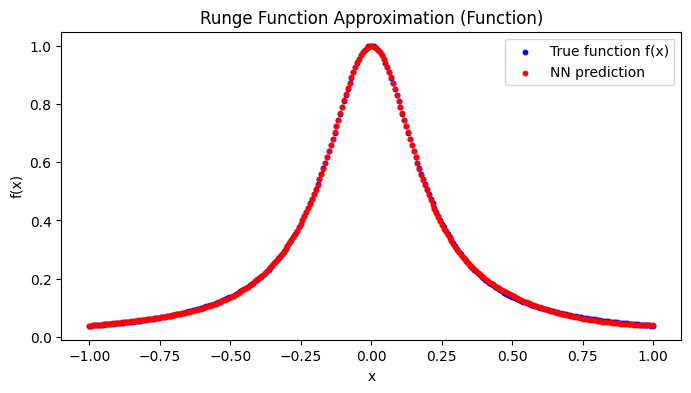

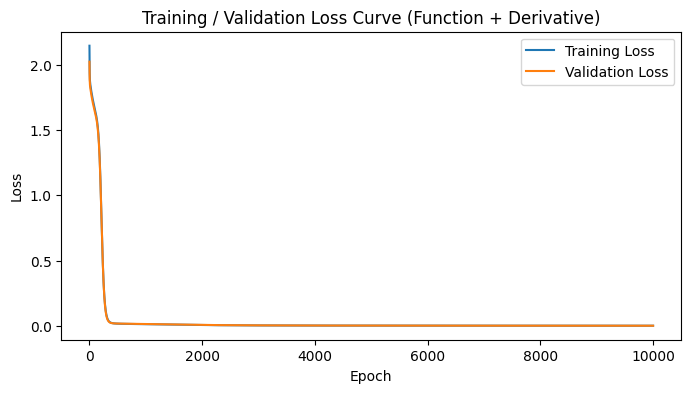

Test function MSE  (f)  = 0.000003
Test derivative MSE (f') = 0.000979


In [9]:
# 1. 產生平滑的 x 範圍，用來畫圖比較
x_plot = np.linspace(-1.0, 1.0, 300).reshape(-1,1)
x_plot_t = torch.tensor(x_plot, dtype=torch.float32)
x_plot_t.requires_grad_(True)

with torch.no_grad():
    # NN 對函數本身的預測
    y_plot_pred = model(x_plot_t).detach().numpy()

# 真實函數
y_plot_true = runge_function(x_plot)

# 2. 畫出 f(x) vs NN(x)
plt.figure(figsize=(8,4))
plt.scatter(x_plot, y_plot_true, color='blue',  s=10, label='True function f(x)')
plt.scatter(x_plot, y_plot_pred, color='red',   s=10, label='NN prediction')
plt.title("Runge Function Approximation (Function)")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# 3. 畫訓練 / 驗證 loss 曲線
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses,   label="Validation Loss")
plt.title("Training / Validation Loss Curve (Function + Derivative)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 4. 在測試集上評估 MSE (f) 和 MSE (f')
with torch.no_grad():
    # function MSE
    y_test_pred = model(x_test)
    mse_test_f = criterion(y_test_pred, y_test).item()

# derivative MSE 要用 autograd，不能包在 no_grad() ，因為還是要算 dy/dx
x_test.requires_grad_(True)
y_test_pred_full = model(x_test)
dy_test_pred = torch.autograd.grad(
    outputs=y_test_pred_full,
    inputs=x_test,
    grad_outputs=torch.ones_like(y_test_pred_full),
    create_graph=False,
    retain_graph=False
)[0]

mse_test_df = criterion(dy_test_pred, dy_test).item()
x_test.requires_grad_(False)

print(f"Test function MSE  (f)  = {mse_test_f:.6f}")
print(f"Test derivative MSE (f') = {mse_test_df:.6f}")
